# Natural Language Processing
# Multiclass Text Classification
BBC Text Classification

# Dataset Preparation

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Datasets/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.shape

(2225, 2)

In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
df.text[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

# Stop words

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

sw_list = stopwords.words("english")
df.text = df.text.apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))
df.text[0]

'tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us tivo uk sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take europe lack high-definition programming. people forward wind adverts also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cable satellite companies worried means terms a

# Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df.text = df.text.apply(lemmatize_text)

In [ ]:
df.text[:5]

0    [tv, future, hand, viewer, home, theatre, syst...
1    [worldcom, bos, left, book, alone, former, wor...
2    [tiger, wary, farrell, gamble, leicester, say,...
3    [yeading, face, newcastle, fa, cup, premiershi...
4    [ocean, twelve, raid, box, office, ocean, twel...
Name: text, dtype: object

# One Hot Encode

In [ ]:
dfLabels = pd.get_dummies(df.category)
dfNew = pd.concat([df, dfLabels], axis=1)
dfNew = dfNew.drop(labels=['category'], axis=1)
dfNew.head(3)

,text,business,entertainment,politics,sport,tech
0,"[tv, future, hand, viewer, home, theatre, syst...",0,0,0,0,1
1,"[worldcom, bos, left, book, alone, former, wor...",1,0,0,0,0
2,"[tiger, wary, farrell, gamble, leicester, say,...",0,0,0,1,0


# Train-Test Split

In [ ]:
X = dfNew.values[:, 0]
y = dfNew.values[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token='x', lower=True)

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
XTrainSeq = tokenizer.texts_to_sequences(X_train)
XTestSeq = tokenizer.texts_to_sequences(X_test)
XTrainPad = pad_sequences(XTrainSeq)
XTestPad = pad_sequences(XTestSeq)

In [ ]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# Model Training and Validation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_regularizer='l2')),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=5, activation='softmax')
])

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.9) and (logs.get('val_accuracy') > 0.9)):
      self.model.stop_training = True
      print("\nAccuracy has exceeded 90%!")

callbacks = myCallback()

In [ ]:
hist = model.fit(XTrainPad, y_train, epochs=30, validation_data=(XTestPad, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
56/56 - 16s - loss: 2.2833 - accuracy: 0.2494 - val_loss: 1.8786 - val_accuracy: 0.3258 - 16s/epoch - 283ms/step
Epoch 2/30
56/56 - 6s - loss: 1.3247 - accuracy: 0.5230 - val_loss: 0.9542 - val_accuracy: 0.6292 - 6s/epoch - 116ms/step
Epoch 3/30
56/56 - 6s - loss: 0.4605 - accuracy: 0.8775 - val_loss: 0.5395 - val_accuracy: 0.8494 - 6s/epoch - 114ms/step
Epoch 4/30
56/56 - 6s - loss: 0.1517 - accuracy: 0.9815 - val_loss: 0.4729 - val_accuracy: 0.8629 - 6s/epoch - 115ms/step
Epoch 5/30
56/56 - 7s - loss: 0.0890 - accuracy: 0.9949 - val_loss: 0.4411 - val_accuracy: 0.8809 - 7s/epoch - 123ms/step
Epoch 6/30

Accuracy has exceeded 90%!
56/56 - 6s - loss: 0.0553 - accuracy: 0.9989 - val_loss: 0.3865 - val_accuracy: 0.9079 - 6s/epoch - 115ms/step


# Accuracy and Loss Plot

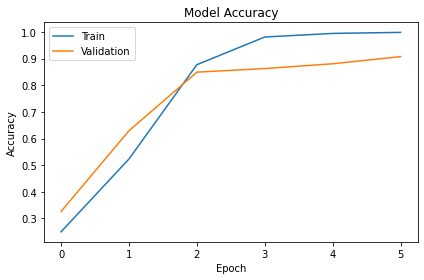

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

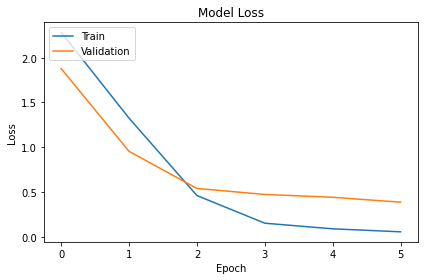

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()